In [43]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
RANDOM_SEED = 42

# Specify each path

In [44]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [45]:
NUM_CLASSES = 6

# Dataset reading

In [46]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [47]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [49]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
b = pd.DataFrame(X_dataset_check)
print(b)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
1      0.0  0.0  0.0 -0.125436 -0.097561 -0.233449 -0.292683 -0.177700   
2      0.0  0.0  0.0 -0.122378 -0.101399 -0.227273 -0.293706 -0.174825   
3      0.0  0.0  0.0 -0.125874 -0.090909 -0.230769 -0.283217 -0.178322   
4      0.0  0.0  0.0 -0.125874 -0.087413 -0.237762 -0.283217 -0.181818   
...    ...  ...  ...       ...       ...       ...       ...       ...   
19455  5.0  0.0  0.0 -0.173469 -0.088435 -0.282313 -0.231293 -0.231293   
19456  5.0  0.0  0.0 -0.194346 -0.095406 -0.303887 -0.233216 -0.261484   
19457  5.0  0.0  0.0 -0.195730 -0.092527 -0.306050 -0.227758 -0.259786   
19458  5.0  0.0  0.0 -0.192171 -0.096085 -0.295374 -0.234875 -0.256228   
19459  5.0  0.0  0.0 -0.197842 -0.100719 -0.312950 -0.237410 -0.266187   

             8         9   ...        33        34        35        36  \
0     -0.468531 -0.027972  ... -0.003

In [50]:
b.groupby(0).size()


0
0.0    4697
1.0    3166
2.0    2837
3.0    2931
4.0    3257
5.0    2572
dtype: int64

# Model building

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [55]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [60]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 98/115 [========================>.....] - ETA: 0s - loss: 0.9467 - accuracy: 0.6223
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 0s 2ms/step - loss: 0.9430 - accuracy: 0.6238 - val_loss: 0.6189 - val_accuracy: 0.8475
Epoch 2/1000
100/115 [=========================>....] - ETA: 0s - loss: 0.9296 - accuracy: 0.6265
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 0s 3ms/step - loss: 0.9263 - accuracy: 0.6273 - val_loss: 0.5941 - val_accuracy: 0.8518
Epoch 3/1000
 88/115 [=====================>........] - ETA: 0s - loss: 0.9126 - accuracy: 0.6405
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
115/115 [==============================] - 0s 3ms/step - loss: 0.9102 - accuracy: 0.6415 - val_loss: 0.5930 - val_accuracy: 0.8721
Epoch 4/1000
110/115 [===========================>..] - ETA: 0s - loss: 0.9099 - accu

In [ ]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

39/39 [==============================] - 0s 924us/step - loss: 0.5635 - accuracy: 0.8573


In [ ]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 77ms/step
[0.01278692 0.34727216 0.29484895 0.00879214 0.32810673 0.00819318]
1


# Draw Loss and Accuracy

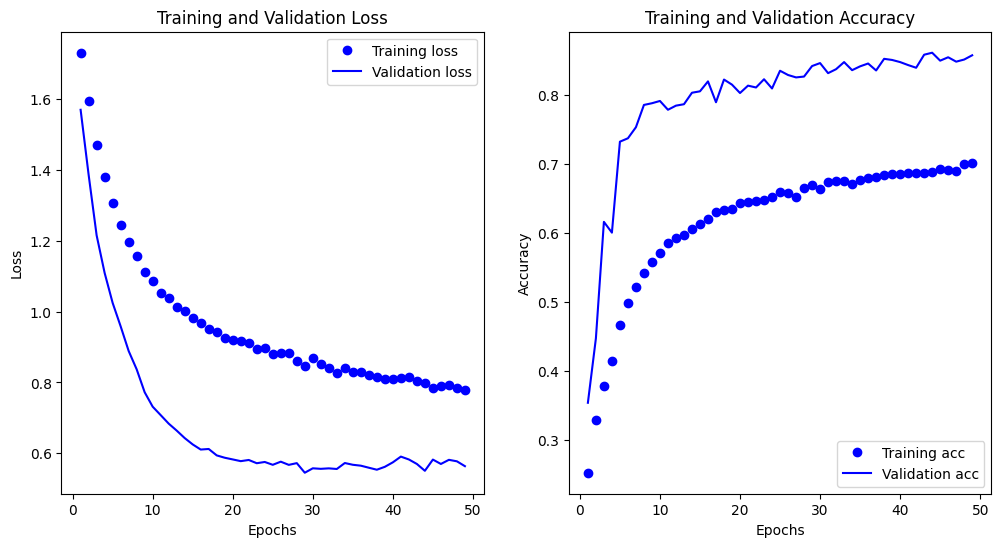

In [ ]:
import matplotlib.pyplot as plt

# Lấy thông tin từ callback tùy chỉnh
mae = custom_metrics_callback.mae
mse = custom_metrics_callback.mse
rmse = custom_metrics_callback.rmse
r_squared = custom_metrics_callback.r_squared

# Vẽ biểu đồ
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'bo', label='MAE')
plt.plot(epochs, mse, 'r', label='MSE')
plt.plot(epochs, rmse, 'g', label='RMSE')
plt.plot(epochs, r_squared, 'y', label='R-squared')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Evaluation metrics')
plt.legend()
plt.show()


# Confusion matrix

153/153 [==============================] - 0s 946us/step


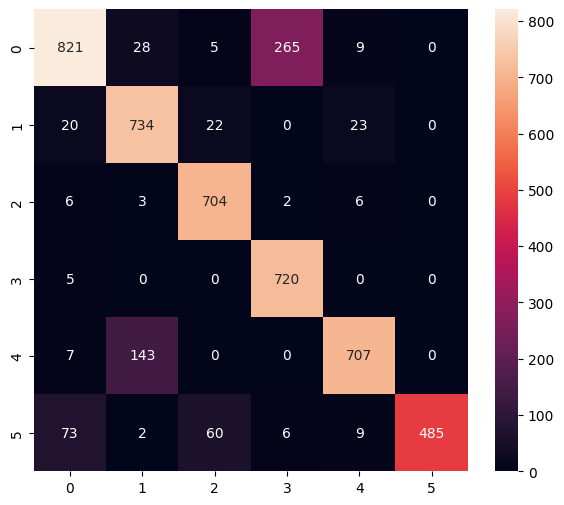

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1128
           1       0.81      0.92      0.86       799
           2       0.89      0.98      0.93       721
           3       0.73      0.99      0.84       725
           4       0.94      0.82      0.88       857
           5       1.00      0.76      0.87       635

    accuracy                           0.86      4865
   macro avg       0.87      0.87      0.86      4865
weighted avg       0.87      0.86      0.86      4865



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [ ]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpb5lf75ah\assets


6660

# Inference test

In [ ]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [ ]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [ ]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.01278692 0.34727207 0.2948489  0.00879214 0.3281068  0.00819317]
1
